#  3 Exploratory Data Analysis

## 3.1 Imports

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from scipy import stats
import scipy.stats
from scipy.stats import chi2
from library.sb_utils import save_file

## 3.2 Load the Data

In [3]:
df = pd.read_csv('../Data/train_data_cleaned.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cc_num                   1296675 non-null  int64  
 1   merchant                 1296675 non-null  object 
 2   amt                      1296675 non-null  float64
 3   first                    1296675 non-null  object 
 4   last                     1296675 non-null  object 
 5   street                   1296675 non-null  object 
 6   city                     1296675 non-null  object 
 7   state                    1296675 non-null  object 
 8   zip                      1296675 non-null  int64  
 9   lat                      1296675 non-null  float64
 10  long                     1296675 non-null  float64
 11  city_pop                 1296675 non-null  int64  
 12  job                      1296675 non-null  object 
 13  trans_num                1296675 non-null 

In [5]:
#change the name of some of the columns to make them more clear.

df=df.rename(columns={'cc_num': 'account_number' , 'amt': 'trans_amount', 'first':'first_name', 'last':'last_name'})

## 3.3 Explore the Data

In [6]:
#Print the amount details for Fraudulent Transaction
fraud= df[df['is_fraud']==1]
fraud.trans_amount.describe()

count    7506.000000
mean      531.320092
std       390.560070
min         1.060000
25%       245.662500
50%       396.505000
75%       900.875000
max      1376.040000
Name: trans_amount, dtype: float64

In [7]:
#Print the amount details for Normal Transaction
valid= df[df['is_fraud']==0]
valid.trans_amount.describe()

count    1.289169e+06
mean     6.766711e+01
std      1.540080e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.728000e+01
75%      8.254000e+01
max      2.894890e+04
Name: trans_amount, dtype: float64

As we can clearly notice from this, the average money transaction for the fraudulent ones is more and it is obvious that the data is imbalanced.

### 3.3.1 Feature Correlation Heatmap

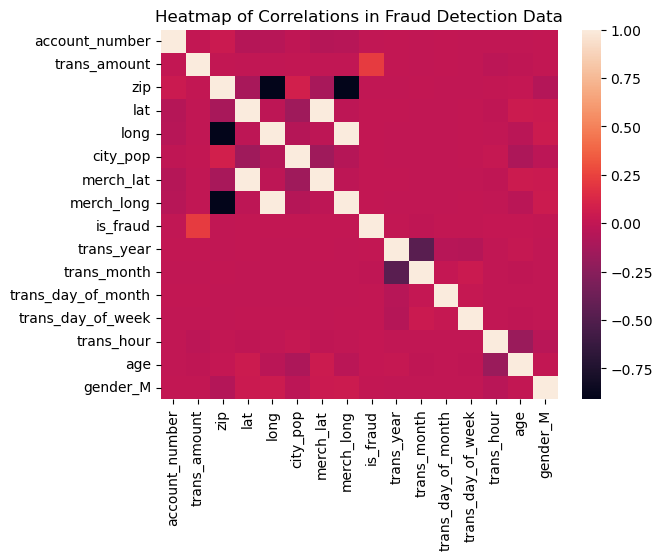

In [8]:
#plotting the correlation matrix
cols= ['account_number', 'trans_amount', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'trans_year', 'trans_month', 'trans_day_of_month', 'trans_day_of_week', 'trans_hour', 'age', 'gender_M']
sns.heatmap(df[cols].corr())
plt.title(f'Heatmap of Correlations in Fraud Detection Data');

In the HeatMap we can clearly see that most of the features do not correlate to other features but there are some features that either has a positive or a negative correlation with each other. We can see some correlation between is_fraud and Amount.

### 3.3.2 Boxplots of numeric features against fraud feature

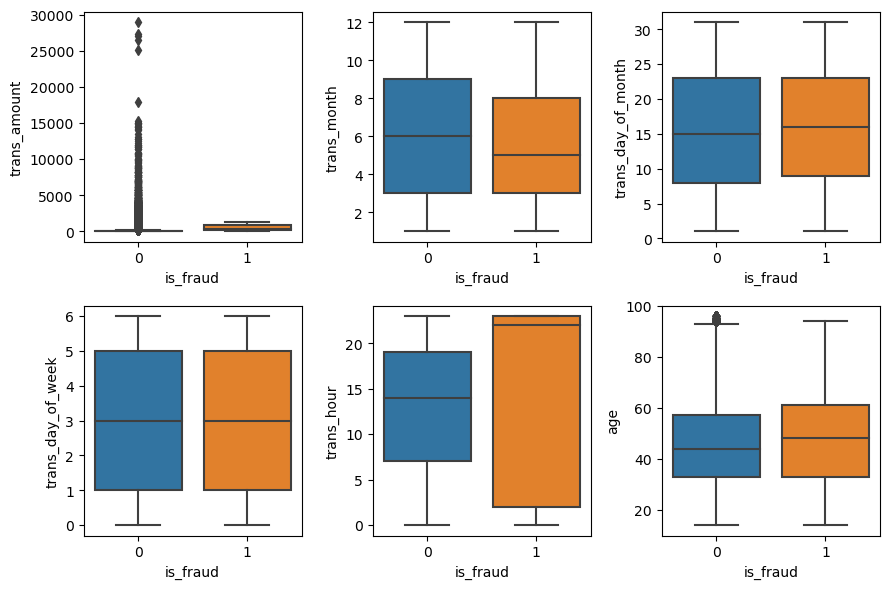

In [9]:
names = ['trans_amount','trans_month', 'trans_day_of_month', 'trans_day_of_week', 'trans_hour', 'age']

ncols = len(names)
fig, axes = plt.subplots(2,3, figsize=(9,6))

for name, ax in zip(names, axes.flatten()):
        sns.boxplot(y=name, x= "is_fraud", data=df, orient='v', ax=ax)


plt.tight_layout()
plt.show();


### 3.3.3  Visualizing Data

#### Transaction Amount

In [10]:
# perform t-test to find if transaction amount is a significant feature
rvs1 = df[df['is_fraud']==1]['trans_amount']
rvs2 = df[df['is_fraud']==0]['trans_amount']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=256.07818064818656, pvalue=0.0)

In [11]:
# sns.histplot(data=df, x='amt', hue= 'is_fraud')
# plt.yscale('log')
# plt.xscale('log')
# plt.title('Histogram of Transaction Amount Distribution')
# plt.show();

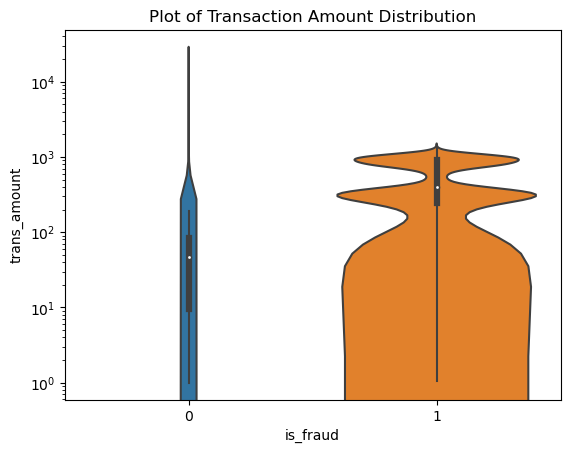

In [12]:
sns.violinplot(data=df, x='is_fraud',y="trans_amount")
plt.yscale('log')
plt.title('Plot of Transaction Amount Distribution')

plt.show();

> From the p-value of 0.0 it is obvious that `trans_amount` is a significant feature in our prediction model and from the histogram we can see that most of the fraud transactions were less than `$25`, or in the range of `$200` to `$1000`. 

Next, we perform chi2_test for the categorical features to find if the feature is significant.

Null Hypothesis (H0): There is no substantial relationship between the two variables.

Alternative Hypothesis (H1): There is a substantial relationship between variables

#### Transaction Month

In [13]:
# perform chi2-test to find if transaction month is a significant feature

ct_table_ind=pd.crosstab(df['trans_month'], df['is_fraud'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

chi2 statistic:     465.79
p-value:            6.2489e-93
degrees of freedom: 11


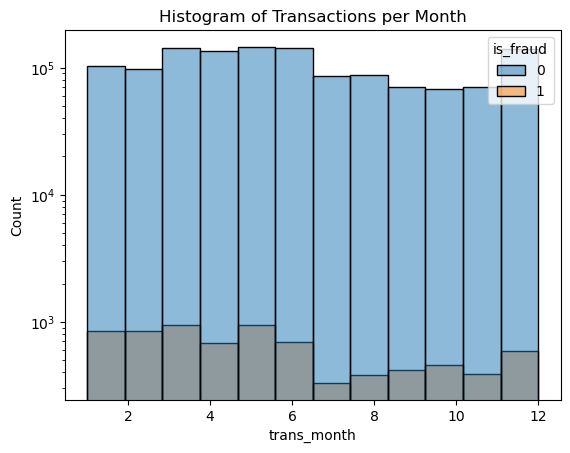

In [14]:
sns.histplot(data=df, x='trans_month', hue= 'is_fraud', bins=12)
plt.yscale('log')
plt.title('Histogram of Transactions per Month')
plt.show();

In [15]:
month_length= len(df['trans_month'].unique())
fraud_props= []
for i in range(1, month_length+1):
    df_month = df.trans_month[df['trans_month']==i].count()
    df_month_fraud = df.trans_month[(df['trans_month']==i) & (df['is_fraud']==1)].count()
    fraud_prop= (df_month_fraud/df_month)*100
    fraud_props.append(fraud_prop)
    
df_trans_month = pd.DataFrame(fraud_props, index=[i for i in range(1,13)], columns= ['fraud_prop'])


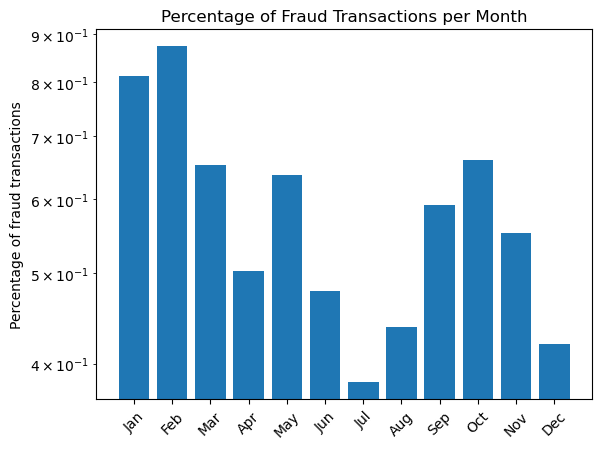

In [16]:
months= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot a bar-chart for proportation of fraud transaction per month
_= plt.bar(df_trans_month.index, df_trans_month['fraud_prop'])
_= plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], months, rotation= 45)
_= plt.ylabel('Percentage of fraud transactions')
_= plt.yscale('log')
_= plt.title('Percentage of Fraud Transactions per Month')
plt.show()

> From the p-value it is obvious that `trans_month` is a significant feature in our prediction model and from the histogram we can see the total number of transactions per month are pretty close for all months. However, from the
proportion plot we can see that the proportion of fraud transactions in January and February are highest followed by October. July had the lowest percentage of fraud transactions. 


#### Transaction Day of Month

In [17]:
# perform chi2-test to find if transaction Day of the Month is a significant feature

ct_table_ind=pd.crosstab(df['trans_day_of_month'], df['is_fraud'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

chi2 statistic:     270.05
p-value:            1.9603e-40
degrees of freedom: 30


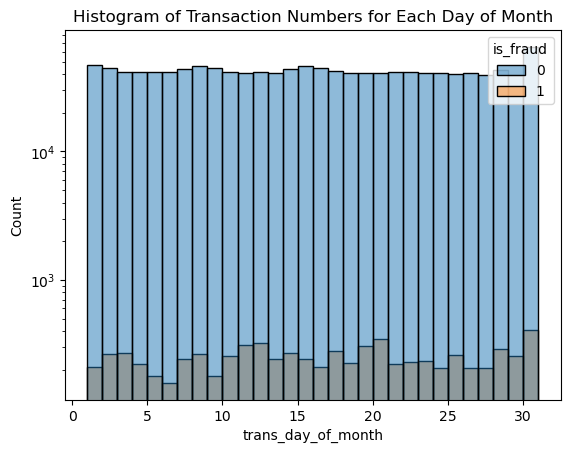

In [18]:
sns.histplot(data=df, x='trans_day_of_month', hue= 'is_fraud', bins=30)
plt.yscale('log')
plt.title('Histogram of Transaction Numbers for Each Day of Month')
plt.show();

In [19]:
day_length= len(df['trans_day_of_month'].unique())
fraud_props= []
for i in range(1, day_length+1):
    df_day = df.trans_day_of_month[df['trans_day_of_month']==i].count()
    df_day_fraud = df.trans_day_of_month[(df['trans_day_of_month']==i) & (df['is_fraud']==1)].count()
    fraud_prop= (df_day_fraud/df_day)*100
    fraud_props.append(fraud_prop)
    
df_trans_day = pd.DataFrame(fraud_props, index=[i for i in range(1,32)], columns= ['fraud_prop'])


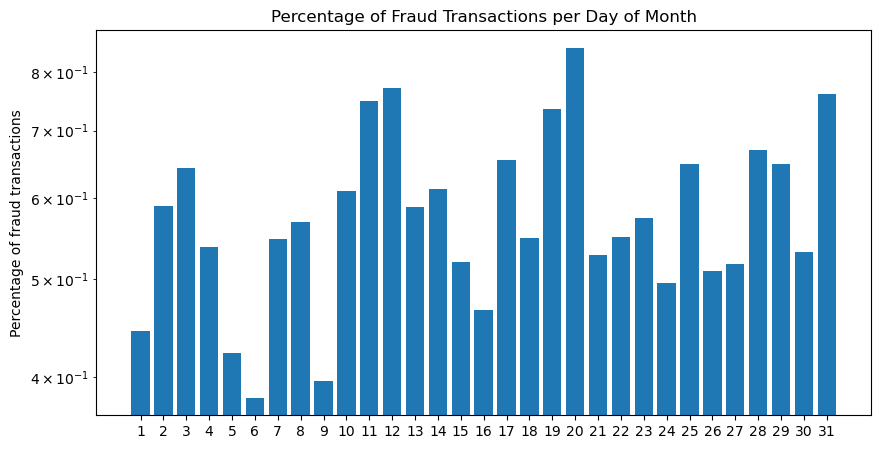

In [20]:
Days= [i for i in range (1,32)]

# Plot a bar-chart for proportation of fraud transaction per month

fig, ax= plt.subplots(figsize=(10,5))
_= plt.bar(df_trans_day.index, df_trans_day['fraud_prop'])
_= plt.xticks(Days)
_= plt.ylabel('Percentage of fraud transactions')
_= plt.yscale('log')
_= plt.title('Percentage of Fraud Transactions per Day of Month')
plt.show()

> From the p-value it is obvious that `trans_day_of_month` is also a significant feature in our prediction model and from the histogram we can see the total number of transactions per day in month are pretty much the same for all days.  However, from the proportion plot we can see that the percent of fraud transactions in the first 10 days of the month are lower than the rest of the month. 

#### Transaction Day of Week

In [21]:
# perform chi2_test to find if 'transaction day of week is a significant feature

ct_table_ind=pd.crosstab(df['trans_day_of_week'], df['is_fraud'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

chi2 statistic:     185.51
p-value:            2.2877e-37
degrees of freedom: 6


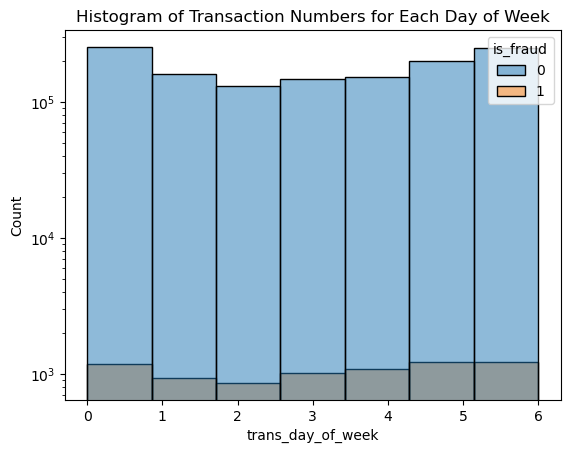

In [22]:
sns.histplot(data=df, x='trans_day_of_week', hue= 'is_fraud', bins=7)
plt.yscale('log')
plt.title('Histogram of Transaction Numbers for Each Day of Week')
plt.show();

In [23]:
day_length= len(df['trans_day_of_week'].unique())
fraud_props= []
for i in range(0, day_length):
    df_day = df.trans_day_of_week[df['trans_day_of_week']==i].count()
    df_day_fraud = df.trans_day_of_week[(df['trans_day_of_week']==i) & (df['is_fraud']==1)].count()
    fraud_prop= (df_day_fraud/df_day)*100
    fraud_props.append(fraud_prop)
    
df_trans_day = pd.DataFrame(fraud_props, index=[i for i in range(1,8)], columns= ['fraud_prop'])


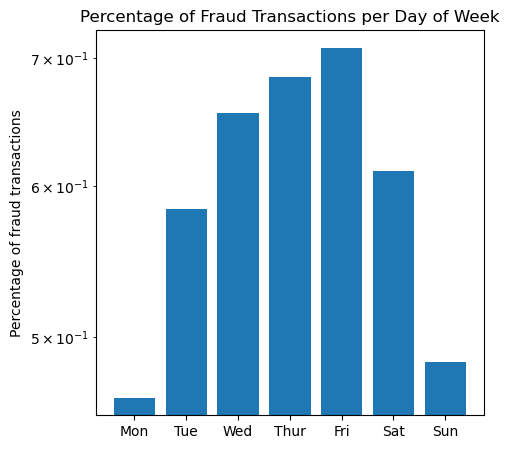

In [24]:
Days= [i for i in range (1,8)]

# Plot a bar-chart for proportation of fraud transaction per month

fig, ax= plt.subplots(figsize=(5,5))
_= plt.bar(df_trans_day.index, df_trans_day['fraud_prop'])
_= plt.xticks(Days, ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
_= plt.ylabel('Percentage of fraud transactions')
_= plt.yscale('log')
_= plt.title('Percentage of Fraud Transactions per Day of Week')
plt.show()

> From the p-value it is obvious that `trans_day_of_week` is a significant feature in our prediction model and from the histogram we can see the total number of transactions per day of week are pretty close for all days. However, from the proportion plot we can see that the proportion of fraud transactions are the highest on Friday, followed by Thursday and Wednesday. Monday had the least percentage of fraud transactions.

#### Transaction Hour

In [25]:
# perform chi2-test to find if 'transaction hour is a significant feature

ct_table_ind=pd.crosstab(df['trans_hour'], df['is_fraud'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

chi2 statistic:     18244
p-value:            0
degrees of freedom: 23


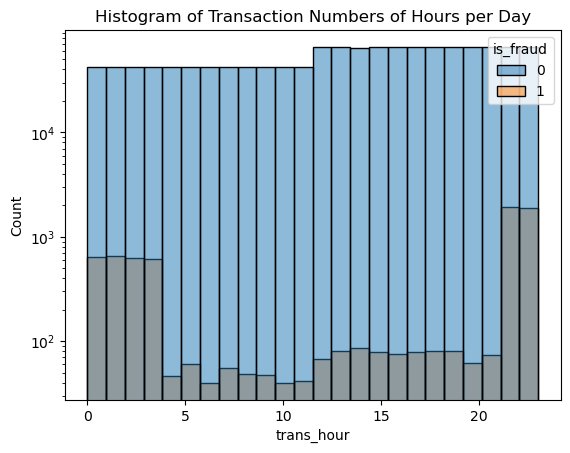

In [26]:
sns.histplot(data=df, x='trans_hour', hue= 'is_fraud', bins=24)
plt.yscale('log')
plt.title('Histogram of Transaction Numbers of Hours per Day')
plt.show();

In [27]:
hour_length= len(df['trans_hour'].unique())
fraud_props= []
for i in range(0, hour_length):
    df_hour = df.trans_hour[df['trans_hour']==i].count()
    df_hour_fraud = df.trans_hour[(df['trans_hour']==i) & (df['is_fraud']==1)].count()
    fraud_prop= (df_hour_fraud/df_hour)*100
    fraud_props.append(fraud_prop)
    
df_trans_hour = pd.DataFrame(fraud_props, index=[i for i in range(0,24)], columns= ['fraud_prop'])


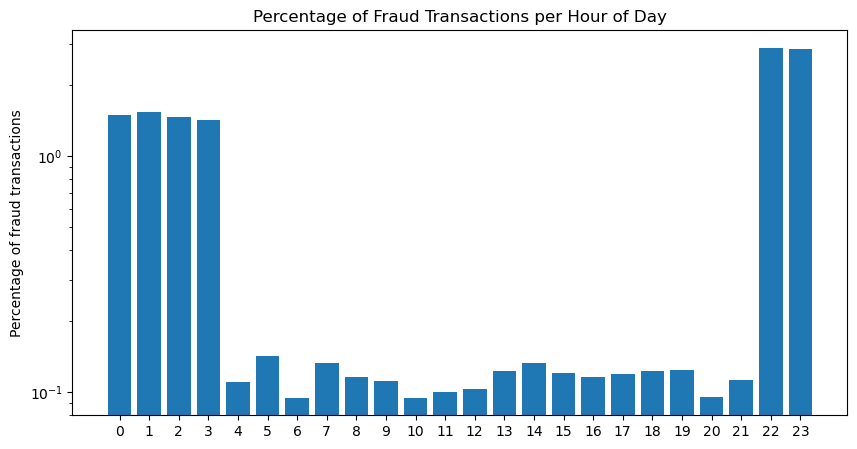

In [28]:
Hours= [i for i in range (0,24)]

# Plot a bar-chart for proportation of fraud transaction per month

fig, ax= plt.subplots(figsize=(10,5))
_= plt.bar(df_trans_hour.index, df_trans_hour['fraud_prop'])
_= plt.xticks(Hours)
_= plt.ylabel('Percentage of fraud transactions')
_= plt.yscale('log')
_= plt.title('Percentage of Fraud Transactions per Hour of Day')
plt.show()

> From the p-value it is obvious that `trans_hour` is a significant feature in our prediction model and from the histogram we can see the total number of transactions per hour are pretty close during the day. However, from the
proportion plot we can see that the percentage of fraud transactions are the highest at late night and early morning (from 10 pm to 3 am)

### Costumer Age

In [29]:
# perform t-test to find if customer age is a significant feature
rvs1=df[df['is_fraud']==1]['age']
rvs2 = df[df['is_fraud']==0]['age']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=14.182078536334389, pvalue=1.1922562185026235e-45)

In [30]:
# sns.histplot(data=df, x='age',  hue= 'is_fraud', element= 'step', bins=20)
# plt.yscale('log')
# # plt.xscale('log')

# plt.title('Histogram of Customer Age Distribution')

# plt.show();

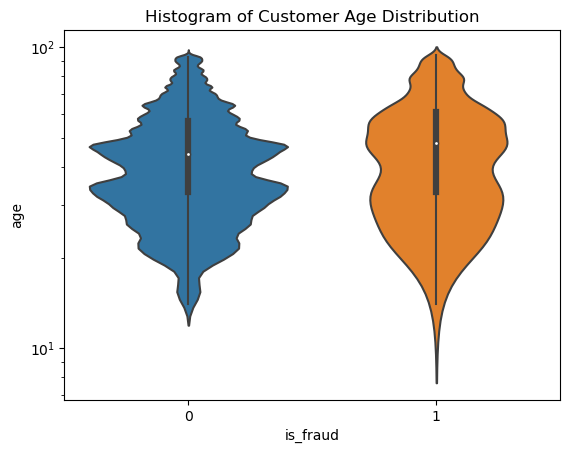

In [35]:
sns.violinplot(data=df, x='is_fraud',y="age")
plt.yscale('log')
plt.title('Histogram of Customer Age Distribution')

plt.show();

> From the p-value it is obvious that `age` is a significant feature in our prediction model and from the histogram we can see that most of the fraud transactions are related to customers between 50 and 60 years old.

In summary, from the test results, it is obvious that transction amount (`amt`), transaction hour (`trans_hour`), costumer age (`age`), and transaction month (`trans_month`) are the most significant features. Transaction day of month (`trans_day_of_month`) and day of week (`trans_day_of_week`) are also significant but at a lower level. 

>Most of the fraud transaction happened on Friday, Thursday, and Wednesday.

>Most of the fraud transactions happened either early in the morning or late at night. 

>Most of the fraud transactions happened in January, Febrauray, and October.

In the next step, we'll split the data to train and test set and will try a few different models to predict the fraud transactions.

In [31]:
# save the data to a new csv file
datapath = '../data'
save_file(df, 'step3_features.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/step3_features.csv"
